# Fine Tuning BERT in Python for Disaster Tweets Classification

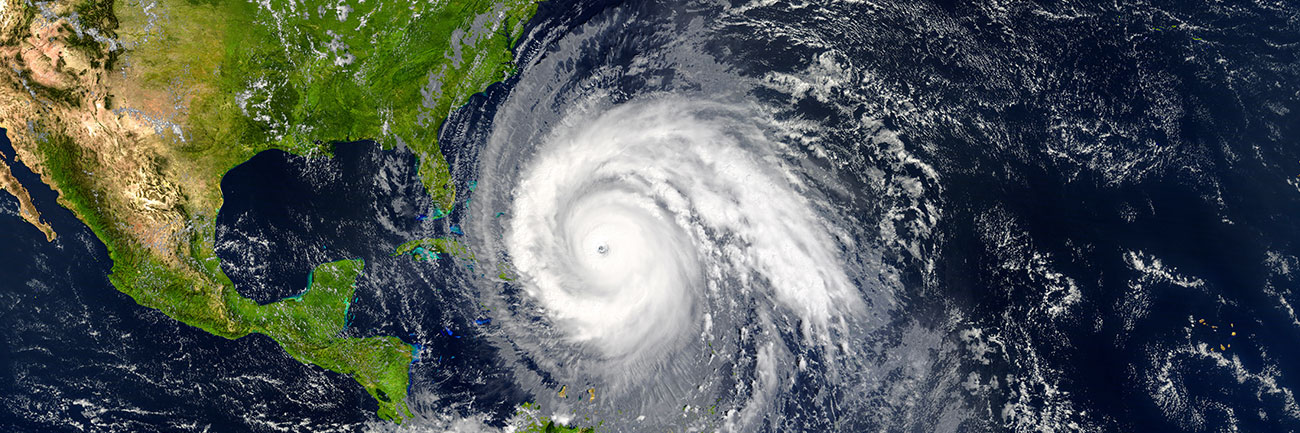

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, identifying such tweets has always been a difficult task because of the ambiguity in the linguistic structure of the tweets and hence it is not always clear whether an individual’s words are actually announcing a disaster.

Kaggle hosted a challenge named Real or Not whose aim was to use the Twitter data of disaster tweets, originally created by the company figure-eight, to classify Tweets talking about real disaster against the ones talking about it metaphorically.

# `BERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

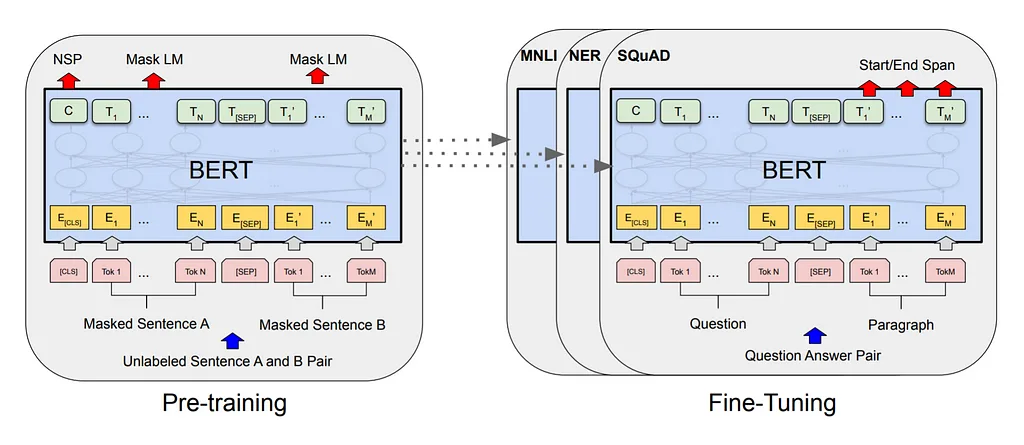

# `KTRAIN`

ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, it is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.

## Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.

# Real or Not? Disaster Tweets Classifications

In [6]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

# Download Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
#tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')
#/content/drive/MyDrive/Data/mytrain.xlsx
#tweet = pd.read_csv('/content/drive/MyDrive/Data/mytrain.xlsx')


In [8]:
#tweet = pd.read_excel('/content/drive/MyDrive/Data/mytrain.xlsx', dtype = str)
tweet = pd.read_csv('/content/drive/MyDrive/Data/mytrain.csv')

In [67]:
tweet.head()

,Sentiment,text,target
0,neutral,!,2
1,neutral,',2
2,disappointed,' (,1
3,neutral,' ( the cockettes,2
4,disappointed,' ( the cockettes ),1


In [9]:
tweet.shape

(239232, 3)

In [10]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239232 entries, 0 to 239231
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentiment  239232 non-null  object
 1   text       239232 non-null  object
 2   target     239232 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.5+ MB


### Target Class Distribution

# Exploratory Data Analysis

In [11]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Emotion')

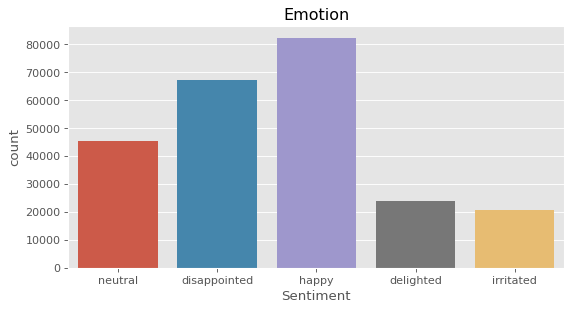

In [12]:
sns.countplot('Sentiment', data=tweet)
plt.title('Emotion')

In [13]:
tweet['Sentiment'].value_counts()

happy           82336
disappointed    67278
neutral         45232
delighted       23845
irritated       20541
Name: Sentiment, dtype: int64

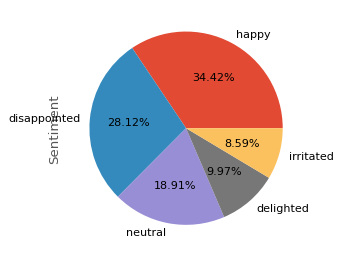

In [14]:
tweet['Sentiment'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

In [15]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-edzas36r
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-edzas36r
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp36-none-any.whl size=11742 sha256=dd8444ab4dc610e9d457c1f38a77046bffeb18c6526a73ffbab786be3fc210da
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qxflrji/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [16]:
import preprocess_kgptalkie as kgp

In [17]:
tweet = kgp.get_basic_features(tweet)

In [18]:
tweet.head()
tweet

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,neutral,!,2,1,1,1.000000,0,0,0,0,0
1,neutral,',2,1,1,1.000000,0,0,0,0,0
2,disappointed,' (,1,2,2,1.000000,0,0,0,0,0
3,neutral,' ( the cockettes,2,14,4,3.500000,1,0,0,0,0
4,disappointed,' ( the cockettes ),1,15,5,3.000000,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
239227,disappointed,your standard Hollywood bio-pic,1,28,4,7.000000,1,0,0,0,0
239228,disappointed,your typical ` fish out of water ' story,1,32,9,3.555556,3,0,0,0,0
239229,disappointed,zero .,1,5,2,2.500000,0,0,0,1,0
239230,delighted,zippy jazzy score,4,15,3,5.000000,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


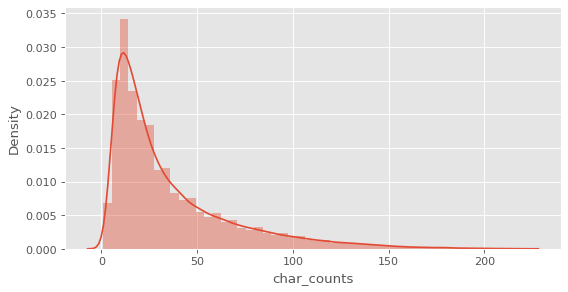

In [19]:
sns.distplot(tweet['char_counts'])

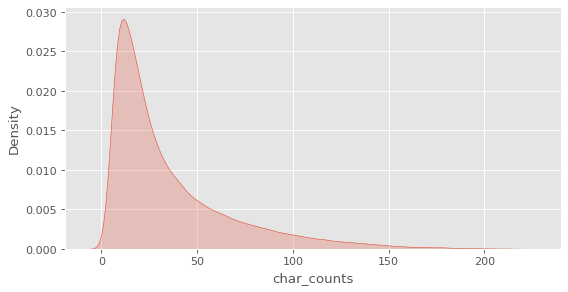

In [20]:
sns.kdeplot(tweet['char_counts'], shade=True)

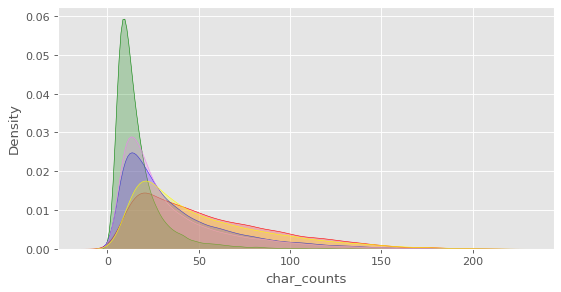

In [21]:
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['char_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['char_counts'], shade=True, color='violet')
sns.kdeplot(tweet[tweet['target']==4]['char_counts'], shade=True, color='yellow')

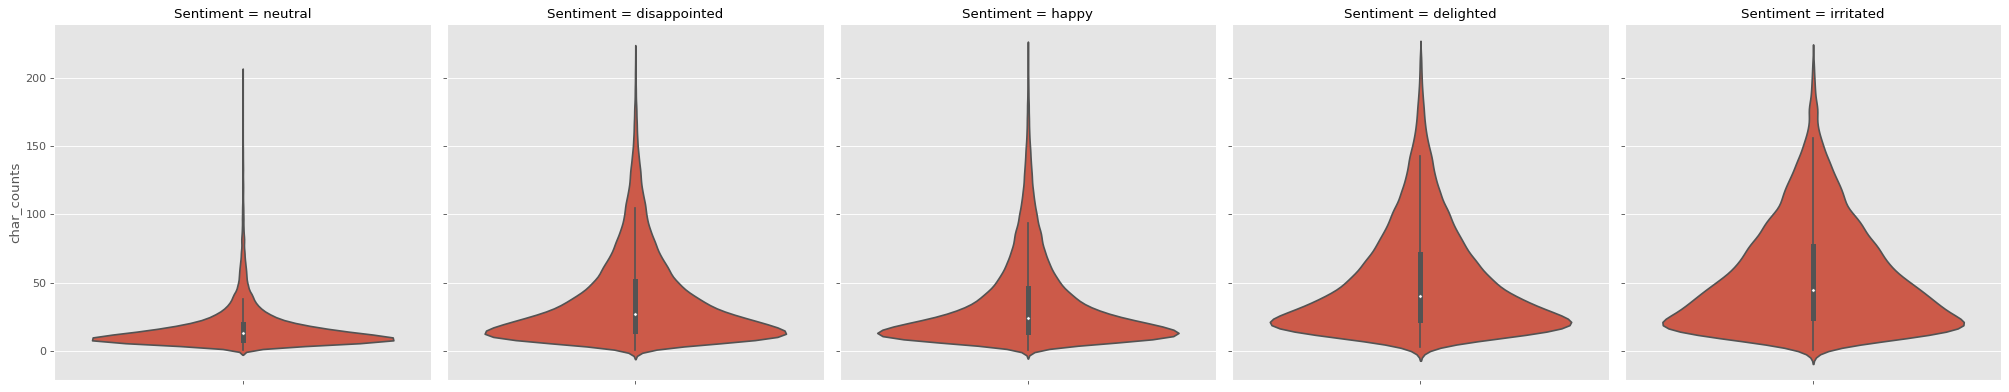

In [22]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='Sentiment')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

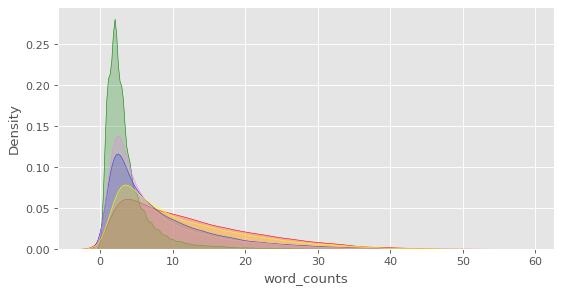

In [23]:
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['word_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['word_counts'], shade=True, color='violet')
sns.kdeplot(tweet[tweet['target']==4]['word_counts'], shade=True, color='yellow')


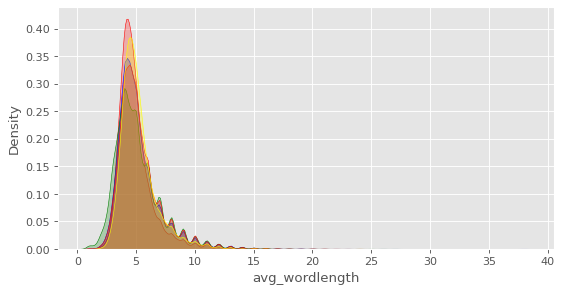

In [24]:
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['avg_wordlength'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==4]['avg_wordlength'], shade=True, color='yellow')


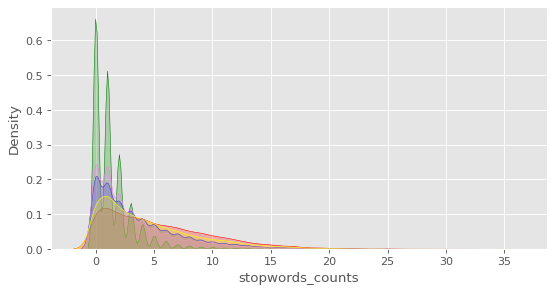

In [25]:
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['stopwords_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['stopwords_counts'], shade=True, color='violet')
sns.kdeplot(tweet[tweet['target']==4]['stopwords_counts'], shade=True, color='yellow')


In [26]:
tweet.columns

Index(['Sentiment', 'text', 'target', 'char_counts', 'word_counts',
       'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [27]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [28]:
top20 = freqs[100:120]

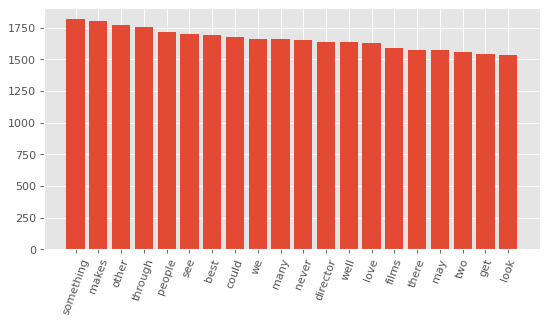

In [30]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [31]:
least20 = freqs[-20:]
least20

Fubar              2
Rewarding          2
Mixes              2
Zany               2
Oozes              2
Gently             2
Light-years        2
Affirms            2
Quick              2
Equlibrium         2
Compassionately    2
Hopelessly         2
100%               1
UNK                1
-1999              1
9.5                1
08-Oct             1
09-Nov             1
Sep-11             1
-1984              1
dtype: int64

In [32]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [33]:
bigram[-20:]

[('10 years', 19),
 ('10 year', 18),
 ('10 worst', 17),
 ('10 times', 16),
 ('10 the', 15),
 ('10 set', 14),
 ('10 seconds', 13),
 ('10 or', 12),
 ('10 minutes', 11),
 ('10 inch', 10),
 ('10 course', 9),
 ('10 complete', 8),
 ('10 but', 7),
 ('10 000', 6),
 ('09 nov', 5),
 ('08 oct', 4),
 ('007 clone', 3),
 ('007 can', 2),
 ('000 times', 1),
 ('000 leagues', 0)]

### One-Shot Data Cleaning

In [34]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [35]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'drive'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [99]:
tweet.head()['text']

0                 
1                 
2                 
3    the cockettes
4    the cockettes
Name: text, dtype: object

In [ ]:
# kgp.get_ngram(tweet, 'text', ngram_range=2)

### Disaster Words Visualization with Word Cloud



In [100]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'the a of and to s is it in that as for its with but andt this movie be an film on not you more than or by like have too from about his at all are one no has so if just much out into story who i does up little what been do only can even some time most characters would was he their bad any your there when they will way good make which could comedy never may them many enough very other something we re get long us through plot off less own being better movies nothing her how people another made life every those should over new really rather minutes action might two without funny before see makes were down had things work character old few big far same audience well director hollywood hard seems films feel ca man love quite thing kind seen between while feels where look because drama go did sense come such here script first ve me end ever back though screen going world still these times almost humor seem watching itself after silly real american picture material know original instead scene

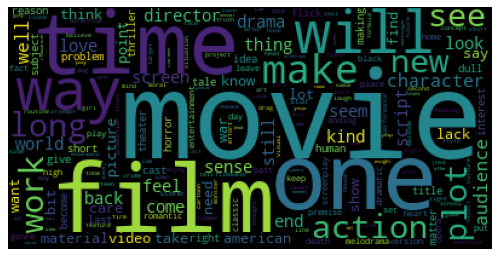

In [101]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

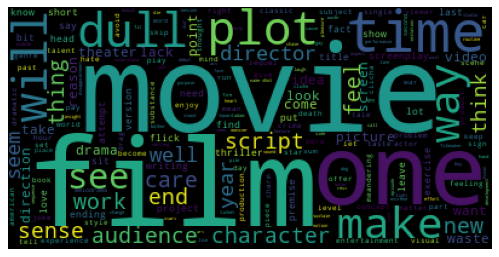

In [102]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [103]:
text = tweet['text']
y = tweet['target']

In [104]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [105]:
X.shape

(239232, 19497)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [107]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [108]:
from sklearn.svm import LinearSVC

In [109]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.43      0.49      4108
           1       0.56      0.59      0.57     13456
           2       0.54      0.51      0.53      9047
           3       0.56      0.62      0.59     16467
           4       0.65      0.52      0.58      4769

    accuracy                           0.56     47847
   macro avg       0.58      0.53      0.55     47847
weighted avg       0.57      0.56      0.56     47847



## Classification with `Word2Vec` and SVM


In [110]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180945 sha256=cebe3b9b1864e68f5cae3cd53c3b9f840511db6e7c6b36e1e0ccbd8dbad9e2d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-hci9bndb/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [111]:
import spacy
import en_core_web_lg

In [112]:
nlp = en_core_web_lg.load()

In [113]:
x = 'cat dog'
doc = nlp(x)

In [114]:
doc.vector.shape

(300,)

In [115]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [116]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [117]:
tweet.head()

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,neutral,,2,1,1,1.0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,neutral,,2,1,1,1.0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,disappointed,,1,2,2,1.0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,neutral,the cockettes,2,14,4,3.5,1,0,0,0,0,"[0.13602, -0.031015, -0.0942, 0.0116125, -0.00..."
4,disappointed,the cockettes,1,15,5,3.0,1,0,0,0,0,"[0.13602, -0.031015, -0.0942, 0.0116125, -0.00..."


In [118]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [119]:
X.shape

(239232, 1)

In [120]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [121]:
X.shape

(239232, 300)

In [122]:
y = tweet['target']

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [124]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.55      0.03      0.06      4108
           1       0.49      0.56      0.52     13456
           2       0.53      0.36      0.43      9047
           3       0.47      0.72      0.57     16467
           4       0.58      0.10      0.17      4769

    accuracy                           0.49     47847
   macro avg       0.52      0.35      0.35     47847
weighted avg       0.50      0.49      0.44     47847

CPU times: user 22min 32s, sys: 1.07 s, total: 22min 33s
Wall time: 22min 34s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Word Embeddings and Classification with Deep Learning


In [125]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [126]:
text

0                                             
1                                             
2                                             
3                                the cockettes
4                                the cockettes
                          ...                 
239227          your standard hollywood biopic
239228    your typical fish out of water story
239229                                    zero
239230                       zippy jazzy score
239231                                     unk
Name: text, Length: 239232, dtype: object

In [127]:
token = Tokenizer()
token.fit_on_texts(text)

In [128]:
vocab_size = len(token.word_index) + 1
vocab_size

19532

In [129]:
print(token.word_index)

{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 's': 6, 'is': 7, 'in': 8, 'it': 9, 'that': 10, 'as': 11, 'with': 12, 'for': 13, 'its': 14, 'film': 15, 'an': 16, 'this': 17, 'movie': 18, 'but': 19, 'you': 20, 'be': 21, 'on': 22, 'andt': 23, 'by': 24, 'his': 25, 'more': 26, 'not': 27, 'about': 28, 'at': 29, 'one': 30, 'than': 31, 'like': 32, 'or': 33, 'from': 34, 'are': 35, 'have': 36, 'all': 37, 'has': 38, 'so': 39, 'story': 40, 'who': 41, 'most': 42, 'too': 43, 'i': 44, 'out': 45, 'into': 46, 'what': 47, 'good': 48, 'if': 49, 'up': 50, 'just': 51, 'much': 52, 'no': 53, 'time': 54, 'their': 55, 'characters': 56, 'some': 57, 'can': 58, 'even': 59, 'comedy': 60, 'does': 61, 'your': 62, 'will': 63, 'little': 64, 'make': 65, 'he': 66, 'way': 67, 'do': 68, 'been': 69, 'life': 70, 'very': 71, 'only': 72, 'funny': 73, 'there': 74, 'any': 75, 'they': 76, 'us': 77, 'enough': 78, 'new': 79, 'her': 80, 'bad': 81, 'was': 82, 'when': 83, 'movies': 84, 'them': 85, 'which': 86, 'director': 87, 'love': 

In [130]:
encoded_text = token.texts_to_sequences(text)

In [132]:
print(encoded_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [133]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [134]:
print(X)

[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 ...
 [ 5178     0     0 ...     0     0     0]
 [ 5109  6578  1039 ...     0     0     0]
 [19531     0     0 ...     0     0     0]]


In [135]:
X.shape

(239232, 40)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [137]:
%%time
# clf = LinearSVC()
# run_SVM(clf, X_train, X_test, y_train, y_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [138]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [139]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           1953200   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [140]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
5981/5981 [==============================] - 130s 21ms/step - loss: -20973170848.5317 - accuracy: 0.2805 - val_loss: -361475342336.0000 - val_accuracy: 0.2812
Epoch 2/5
4781/5981 [======================>.......] - ETA: 25s - loss: -1258803025413.2476 - accuracy: 0.2815

KeyboardInterrupt: ignored

In [ ]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [ ]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [ ]:
vec

array([[ 6, 35,  4, 13, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [ ]:
np.argmax(model.predict(vec), axis = -1)

array([0])

# BERT Model Building and Training

In [141]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 65.7MB/s 
     |████████████████████████████████| 6.8MB 48.6MB/s 
     |████████████████████████████████| 983kB 48.7MB/s 
     |████████████████████████████████| 266kB 51.2MB/s 
     |████████████████████████████████| 1.3MB 45.1MB/s 
     |████████████████████████████████| 1.1MB 43.7MB/s 
     |████████████████████████████████| 471kB 48.9MB/s 
     |████████████████████████████████| 890kB 47.3MB/s 
     |████████████████████████████████| 2.9MB 40.6MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.3-cp36-none-any.whl size=25276312 sha256=97c2f9d71a607659f6b0c023a6f2bbcc09d196374b2eca9f57d8a28c61b0c6a3
  Stored in directory: /root/.cache/pip/wheels/86/cd/9c/ad53b98a3eccf4ddeddccfce99d353781f206a1ac4287ca721
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=c6af38de3abc9bea9d15e6c963e0e177138a732d32b5c4ed6bd7e4e5dd978935
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d

In [36]:
tweet.head()

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,neutral,,2,1,1,1.0,0,0,0,0,0
1,neutral,,2,1,1,1.0,0,0,0,0,0
2,disappointed,,1,2,2,1.0,0,0,0,0,0
3,neutral,the cockettes,2,14,4,3.5,1,0,0,0,0
4,disappointed,the cockettes,1,15,5,3.0,1,0,0,0,0


In [37]:
from ktrain import text
import ktrain

In [38]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [39]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [40]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [41]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
3365/3365 [==============================] - 1434s 420ms/step - loss: 1.0943 - accuracy: 0.5237 - val_loss: 0.8665 - val_accuracy: 0.6310


In [42]:
learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
3365/3365 [==============================] - 1404s 417ms/step - loss: 0.8217 - accuracy: 0.6505 - val_loss: 0.8638 - val_accuracy: 0.6315
Epoch 2/3
3365/3365 [==============================] - 1392s 414ms/step - loss: 0.7960 - accuracy: 0.6614 - val_loss: 0.8523 - val_accuracy: 0.6378
Epoch 3/3
3365/3365 [==============================] - 1409s 419ms/step - loss: 0.7010 - accuracy: 0.7054 - val_loss: 0.8908 - val_accuracy: 0.6327


In [ ]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 2e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 133s 1s/step - loss: 0.3352 - accuracy: 0.8590 - val_loss: 0.4615 - val_accuracy: 0.8228
Epoch 2/3
108/108 [==============================] - 133s 1s/step - loss: 0.3115 - accuracy: 0.8748 - val_loss: 0.5920 - val_accuracy: 0.7480
Epoch 3/3
108/108 [==============================] - 133s 1s/step - loss: 0.1731 - accuracy: 0.9365 - val_loss: 0.5802 - val_accuracy: 0.8346


In [ ]:
# find out best learning rate?
# learner.lr_find()
# learner.lr_plot()

# it may take days or many days to find out.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [63]:
data = ['fast and efficient service']

In [64]:
predictor.predict(data, return_proba=True)

array([[1.0169340e-04, 2.4428619e-03, 6.3893548e-03, 8.4018171e-01,
        1.5088427e-01]], dtype=float32)

In [60]:
predictor.predict(data[1])

'target_4'

In [52]:
classes = predictor.get_classes()

In [53]:
data

['completely waste of time',
 'very satisfied! thanx',
 'highly skilled person, could not be better',
 'faster service! still waiting for a cheque to be issued! use royal mail tracking instead of just blaming them. better staff that actually deal with the issue instead of just parming you off! better wording of emails',
 'great help ',
 'i was given a replacement toothbrush handle as mine had stopped working properly so that is why i am happy',
 'very bad manners agent was rude shouted at me']

In [54]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

4

In [55]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [43]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [61]:
data = ['completely waste of time',
        'very satisfied! thanx',
        'highly skilled person, could not be better',
        'faster service! still waiting for a cheque to be issued! use royal mail tracking instead of just blaming them. better staff that actually deal with the issue instead of just parming you off! better wording of emails',
        'great help ',
        'i was given a replacement toothbrush handle as mine had stopped working properly so that is why i am happy', 
        'very bad manners agent was rude shouted at me']

In [62]:
predictor.predict(data)

['target_0',
 'target_4',
 'target_3',
 'target_1',
 'target_3',
 'target_3',
 'target_0']

In [46]:
predictor.predict(data, return_proba=True)

array([[8.3293074e-01, 1.6416326e-01, 8.1598532e-04, 1.9654541e-03,
        1.2456626e-04],
       [2.0033297e-04, 4.5494069e-03, 4.6336795e-03, 4.7995818e-01,
        5.1065844e-01],
       [1.8721569e-04, 4.4344030e-03, 4.0200744e-03, 5.0894946e-01,
        4.8240888e-01],
       [1.4785935e-01, 8.0880159e-01, 9.1551170e-03, 3.3815350e-02,
        3.6854448e-04],
       [6.8603826e-05, 1.5605345e-03, 1.3010161e-03, 5.9771454e-01,
        3.9935535e-01],
       [2.2070361e-03, 4.9727581e-02, 1.3096162e-02, 7.8453887e-01,
        1.5043040e-01],
       [7.2343153e-01, 2.7035162e-01, 2.5894097e-03, 3.4862263e-03,
        1.4113737e-04]], dtype=float32)

In [48]:
predictor.get_classes()

['target_0', 'target_1', 'target_2', 'target_3', 'target_4']

In [66]:
predictor.save('/content/drive/MyDrive/Data/bert')

In [69]:
!zip -r /content/drive/MyDrive/Data/bert/bert.zip /content/drive/MyDrive/Data/bert

  adding: content/drive/MyDrive/Data/bert/ (stored 0%)
  adding: content/drive/MyDrive/Data/bert/tf_model.h5 (deflated 15%)
  adding: content/drive/MyDrive/Data/bert/tf_model.preproc (deflated 52%)
  adding: content/drive/MyDrive/Data/bert/.ipynb_checkpoints/ (stored 0%)


In [70]:
predictor_load = ktrain.load_predictor('/content/drive/MyDrive/Data/bert')

In [71]:
data = ['completely waste of time',
        'very satisfied! thanx',
        'highly skilled person, could not be better',
        'faster service! still waiting for a cheque to be issued! use royal mail tracking instead of just blaming them. better staff that actually deal with the issue instead of just parming you off! better wording of emails',
        'great help ',
        'i was given a replacement toothbrush handle as mine had stopped working properly so that is why i am happy', 
        'very bad manners agent was rude shouted at me']

In [72]:
predictor_load.get_classes()

['target_0', 'target_1', 'target_2', 'target_3', 'target_4']

In [73]:
predictor_load.predict(data)

['target_0',
 'target_4',
 'target_3',
 'target_1',
 'target_3',
 'target_3',
 'target_0']

In [74]:
predictor_load.predict(data, return_proba=True)

array([[8.3293074e-01, 1.6416326e-01, 8.1598532e-04, 1.9654541e-03,
        1.2456626e-04],
       [2.0033297e-04, 4.5494069e-03, 4.6336795e-03, 4.7995818e-01,
        5.1065844e-01],
       [1.8721569e-04, 4.4344030e-03, 4.0200744e-03, 5.0894946e-01,
        4.8240888e-01],
       [1.4785935e-01, 8.0880159e-01, 9.1551170e-03, 3.3815350e-02,
        3.6854448e-04],
       [6.8603826e-05, 1.5605345e-03, 1.3010161e-03, 5.9771454e-01,
        3.9935535e-01],
       [2.2070361e-03, 4.9727581e-02, 1.3096162e-02, 7.8453887e-01,
        1.5043040e-01],
       [7.2343153e-01, 2.7035162e-01, 2.5894097e-03, 3.4862263e-03,
        1.4113737e-04]], dtype=float32)